# How to train a new language model from scratch using Transformers and Tokenizers

Copyright 2023-24, Denis Rothman. Denis Rothman adapted a Hugging Face reference notebook to pretrain a transformer model.

In **October 2024**, wandb.ai training metrics were added while training. You can now view your model's metrics on Hugging Face.  
In 2023, a hardware accelerator was added.

It is recommended to understand this notebook. The emergence of GPT-3 engines has produced an API that can outperform many trained transformers models. However, to show a transformer what to do with the input datasets, it is essential to understand how they are trained.

The Transformer model of this notebook is a Transformer model named ***KantaiBERT***. ***KantaiBERT*** is trained as a RoBERTa Transformer with DistilBERT architecture. The dataset was compiled from three books by Immanuel Kant downloaded from the [Gutenberg Project](https://www.gutenberg.org/).


***KantaiBERT*** was pretrained with a small model of 84 million parameters using the same number of layers and heads as DistilBert, i.e., 6 layers, 768 hidden size,and 12 attention heads. ***KantaiBERT*** is then fine-tuned for a downstream masked Language Modeling task.

### The Hugging Face original Reference and notes:

Notebook edition (link to original of the reference blogpost [link](https://huggingface.co/blog/how-to-train)).


#Step 1: Loading the dataset

In [1]:
from IPython.display import Image     #This is used for rendering images in the notebook

In [2]:
import requests
from PIL import Image
from io import BytesIO

def get_image_from_github(image_name):

    # The base URL of the image files in the GitHub repository
    base_url = 'https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/main/Notebook%20images/06/'

    # Make the request
    response = requests.get(base_url + image_name)

    # Check if the request was successful
    if response.status_code == 200:
        # Read the image
        image = Image.open(BytesIO(response.content))

        # Return the image
        return image
    else:
        print(f'Error {response.status_code}: Could not access the image file.')
        return None

In [3]:
#1.Load kant.txt using the Colab file manager
#2.Downloading the file from GitHub
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/master/Chapter06/kant.txt --output "kant.txt"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.7M  100 10.7M    0     0  67.7M      0 --:--:-- --:--:-- --:--:-- 67.9M


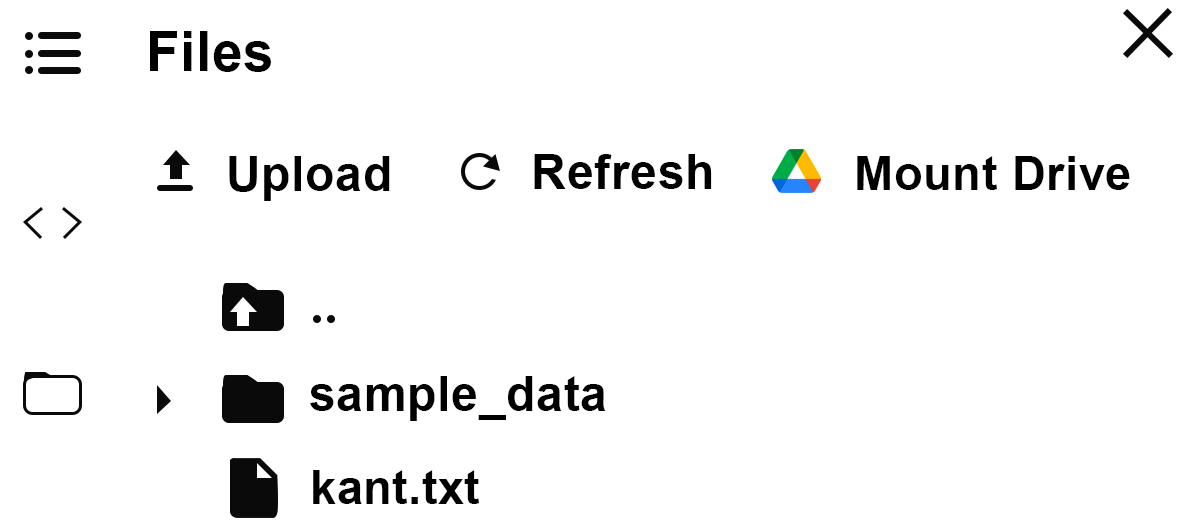

In [4]:
display(get_image_from_github('B19899_06_01.png') or print('Image not found'))

#Step 2: Installing Hugging Face transformers

April 2023 update From Hugging Face Issue 22816:

https://github.com/huggingface/transformers/issues/22816

"The PartialState import was added as a dependency on the transformers development branch yesterday. PartialState was added in the 0.17.0 release in accelerate, and so for the development branch of transformers, accelerate >= 0.17.0 is required.

Downgrading the transformers version removes the code which is importing PartialState."

Denis Rothman: The following cell imports the latest version of Hugging Face transformers but without downgrading it.

To adapt to the Hugging Face upgrade, A GPU accelerator was activated using the Google Colab Pro with the following NVIDIA GPU:
GPU Name: NVIDIA A100-SXM4-40GB

In [1]:
!pip install Transformers==4.46.1
!pip install accelerate==1.0.1
#!pip install --upgrade accelerate
from accelerate import Accelerator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 90.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: Transformers
    Found existing installation: transformers 4.48.3
    Uninstalling transformers-4.48.3:
      Successfully uninstalled transformers-4.48.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━

#Step 3: Training a tokenizer

In [ ]:
from pathlib import Path

from tokenizers import ByteLevelBPETokenizer

paths = [str(x) for x in Path(".").glob("**/*.txt")]

# Read the content from the files, ignoring or replacing invalid characters
file_contents = []
for path in paths:
    try:
        with open(path, 'r', encoding='utf-8', errors='replace') as file:
            file_contents.append(file.read())
    except Exception as e:
        print(f"Error reading {path}: {e}")

# Join the contents into a single string
text = "\n".join(file_contents)

# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()

# Customize training
tokenizer.train_from_iterator([text], vocab_size=52_000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

#Step 4: Saving the files to disk

In [ ]:
import os
token_dir = '/content/KantaiBERT'
if not os.path.exists(token_dir):
  os.makedirs(token_dir)
tokenizer.save_model('KantaiBERT')

In [ ]:
display(get_image_from_github('B19899_06_02.png') or print('Image not found'))

#Step 5: Loading the trained tokenizer files

In [ ]:
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

tokenizer = ByteLevelBPETokenizer(
    "./KantaiBERT/vocab.json",
    "./KantaiBERT/merges.txt",
)

In [ ]:
tokenizer.encode("The Critique of Pure Reason.").tokens

In [ ]:
tokenizer.encode("The Critique of Pure Reason.")

In [ ]:
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=512)

#Step 6: Checking Resource Constraints: GPU and NVIDIA

In [ ]:
!nvidia-smi

In [ ]:
#@title Checking that PyTorch Sees CUDA
import torch
torch.cuda.is_available()

#Step 7: Defining the configuration of the model

In [ ]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=52_000,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

In [ ]:
print(config)

#Step 8: Reloading the tokenizer in transformers

In [ ]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("./KantaiBERT", max_length=512)

#Step 9: Initializing a model from scratch

In [ ]:
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(config=config)
print(model)

## Exploring the parameters

In [ ]:
print(model.num_parameters())

In [ ]:
LP=list(model.parameters())
lp=len(LP)
print(lp)
for p in range(0,lp):
  print(LP[p])

In [ ]:
#Shape of each tensor in the model
LP = list(model.parameters())
for i, tensor in enumerate(LP):
    print(f"Shape of tensor {i}: {tensor.shape}")

In [ ]:
#counting the parameters
np=0
for p in range(0,lp):#number of tensors
  PL2=True
  try:
    L2=len(LP[p][0]) #check if 2D
  except:
    L2=1             #not 2D but 1D
    PL2=False
  L1=len(LP[p])
  L3=L1*L2
  np+=L3             # number of parameters per tensor
  if PL2==True:
    print(p,L1,L2,L3)  # displaying the sizes of the parameters
  if PL2==False:
    print(p,L1,L3)  # displaying the sizes of the parameters

print(np)              # total number of parameters

#Step 10: Building the dataset

In [ ]:
%%time
from transformers import LineByLineTextDataset

dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="./kant.txt",
    block_size=128,
)

#Step 11: Defining a data collator

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

#Step 12: Initializing the trainer

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./KantaiBERT",
    overwrite_output_dir=True,
    num_train_epochs=1, #can be increased
    per_device_train_batch_size=64,
    save_steps=10_000,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

#Step 13: Pretraining the model

In [ ]:
%%time
trainer.train()

#Step 14: Saving the final model (+tokenizer + config) to disk

In [ ]:
trainer.save_model("./KantaiBERT")

In [ ]:
display(get_image_from_github('B19899_06_05.png') or print('Image not found'))

#Step 15: Language modeling with FillMaskPipeline

In [ ]:
from transformers import pipeline

fill_mask = pipeline(
    "fill-mask",
    model="./KantaiBERT",
    tokenizer="./KantaiBERT"
)

In [ ]:
fill_mask("Human thinking involves human <mask>.")